# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

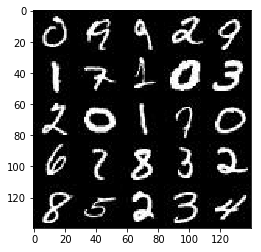

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

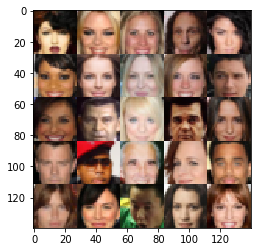

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32)

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/carnd/anaconda3/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/carnd/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/carnd/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/carnd/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def normalize_layer(x):
    return x
    mean=tf.reduce_mean(x,axis =[1,2,3], keep_dims = True)
    var = tf.reduce_mean(x*x,axis =[1,2,3], keep_dims = True) - mean*mean
    norm_x = (x - mean)/tf.sqrt(var)
    return norm_x

In [7]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    drop_rate = 0.05
    x = images
    with tf.variable_scope('discriminator', reuse=reuse):
        filters = 64
        # Input layer is 28x28x3
        x = tf.layers.conv2d(inputs = x, 
             filters = filters, 
             kernel_size = 5, 
             strides = 1,
             kernel_initializer = tf.contrib.layers.xavier_initializer(),
             padding="same")
        x = tf.layers.dropout(x, drop_rate,training = True)
        x = tf.layers.batch_normalization(x, training = True)
        #x = normalize_layer(x)
        x = tf.concat([images,tf.contrib.keras.layers.LeakyReLU(alpha)(x)],3)
        

        for i in range(3):
            x = tf.layers.conv2d(inputs = x, 
                                 filters = filters, 
                                 kernel_size = 5, 
                                 strides = 2,
                                 kernel_initializer = tf.contrib.layers.xavier_initializer(),
                                 padding="same")
            x = tf.layers.dropout(x, drop_rate,training = True)
            x = tf.layers.batch_normalization(x, training = True)
            #x = normalize_layer(x)
            x = tf.contrib.keras.layers.LeakyReLU(alpha)(x)
            
            filters = 2*filters
        #print(x.get_shape().as_list())
        flat = tf.contrib.layers.flatten(x)
        x = tf.layers.dropout(x, drop_rate,training = True)
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    # Why on earth does the test check for the number of args?
    alpha = 0.2
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    init_dim =[-1,7,7,512]
    init_len = 7*7*512
    filters = 512
    drop_rate = 0.5
    with tf.variable_scope('generator', reuse = not is_train):
        # First fully connected layer
        x = tf.layers.dense(z,init_len)
        x = tf.reshape(x, tf.cast(init_dim, tf.int32))
        x = tf.layers.dropout(x, drop_rate, training = is_train)
        x = tf.layers.batch_normalization(x, training = is_train)
        #x = normalize_layer(x)
        x = tf.contrib.keras.layers.LeakyReLU(alpha)(x)
        
        
        # so now we're at 7x7x512
        for i in range(2):
            filters = filters/2
            x = tf.layers.conv2d_transpose(inputs = x, 
                                           filters = int(filters), 
                                           kernel_size =5,
                                           strides = 2,
                                           kernel_initializer = tf.contrib.layers.xavier_initializer(),
                                           padding = 'same')
            x = tf.layers.dropout(x, drop_rate, training = is_train)
            x = tf.layers.batch_normalization(x, training = is_train)
            #x = normalize_layer(x)
            x = tf.contrib.keras.layers.LeakyReLU(alpha)(x)
           
            
        x = tf.layers.conv2d_transpose(inputs = x, 
                                   filters = out_channel_dim, 
                                   kernel_size = 5,
                                   strides = 1,
                                   kernel_initializer = tf.contrib.layers.xavier_initializer(),
                                   padding = 'same')
        #x = tf.layers.batch_normalization(x, training = is_train)
        # Output layer, 28x28x3 
        # rather than mess around with convolutions to get the size just right, let's just trim it
        #logits = tf.slice(x, [0,0,0,0],[-1,28,28,-1])
        logits = x
        out = 0.5*tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=0.95*tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=0.05*tf.ones_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=0.95*tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    dummy, image_width, image_height, out_channel_dim =  data_shape
    input_real, input_z, learning_rate_ph = model_inputs(image_width, image_height, out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate_ph, beta1)
                
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_ph:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_ph:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1,epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(input_z,out_channel_dim, is_train=False),
                                   feed_dict={input_z: sample_z})
                    samples.append(gen_samples)
                    _ = show_generator_output(sess, 9, input_z, out_channel_dim, data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')
    import pickle
    with open('samples.pkl', 'wb') as f:
        pickle.dump(samples, f)
    
    return losses, samples
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4674... Generator Loss: 2.4057
Epoch 1/2... Discriminator Loss: 0.4752... Generator Loss: 2.4641
Epoch 1/2... Discriminator Loss: 0.5545... Generator Loss: 2.5507
Epoch 1/2... Discriminator Loss: 0.4795... Generator Loss: 2.1952
Epoch 1/2... Discriminator Loss: 0.6280... Generator Loss: 1.7207
Epoch 1/2... Discriminator Loss: 0.6406... Generator Loss: 3.2161
Epoch 1/2... Discriminator Loss: 0.5215... Generator Loss: 2.7171
Epoch 1/2... Discriminator Loss: 0.6160... Generator Loss: 2.8007
Epoch 1/2... Discriminator Loss: 0.5900... Generator Loss: 3.0050
Epoch 1/2... Discriminator Loss: 0.8764... Generator Loss: 1.1316


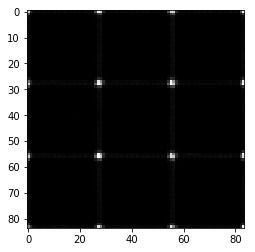

Epoch 1/2... Discriminator Loss: 0.6727... Generator Loss: 2.0347
Epoch 1/2... Discriminator Loss: 0.6508... Generator Loss: 1.5188
Epoch 1/2... Discriminator Loss: 0.7772... Generator Loss: 1.2398
Epoch 1/2... Discriminator Loss: 0.7100... Generator Loss: 2.1337
Epoch 1/2... Discriminator Loss: 0.6293... Generator Loss: 2.4558
Epoch 1/2... Discriminator Loss: 0.6205... Generator Loss: 1.8754
Epoch 1/2... Discriminator Loss: 0.6849... Generator Loss: 2.5635
Epoch 1/2... Discriminator Loss: 0.6040... Generator Loss: 1.8597
Epoch 1/2... Discriminator Loss: 1.2616... Generator Loss: 3.6353
Epoch 1/2... Discriminator Loss: 0.5830... Generator Loss: 2.1571


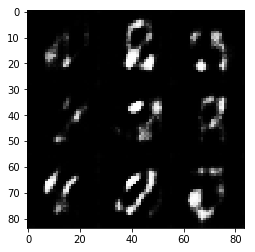

Epoch 1/2... Discriminator Loss: 0.6437... Generator Loss: 2.0883
Epoch 1/2... Discriminator Loss: 0.6367... Generator Loss: 1.6872
Epoch 1/2... Discriminator Loss: 0.6478... Generator Loss: 2.3089
Epoch 1/2... Discriminator Loss: 0.6104... Generator Loss: 2.0812
Epoch 1/2... Discriminator Loss: 0.7838... Generator Loss: 1.1393
Epoch 1/2... Discriminator Loss: 0.6829... Generator Loss: 1.3916
Epoch 1/2... Discriminator Loss: 0.5465... Generator Loss: 2.3999
Epoch 1/2... Discriminator Loss: 0.6273... Generator Loss: 1.8689
Epoch 1/2... Discriminator Loss: 0.5251... Generator Loss: 1.9712
Epoch 1/2... Discriminator Loss: 0.6274... Generator Loss: 2.1604


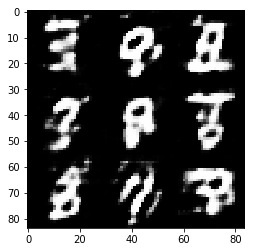

Epoch 1/2... Discriminator Loss: 0.6197... Generator Loss: 3.3284
Epoch 1/2... Discriminator Loss: 0.5489... Generator Loss: 2.0083
Epoch 1/2... Discriminator Loss: 0.7196... Generator Loss: 2.8813
Epoch 1/2... Discriminator Loss: 0.5596... Generator Loss: 2.4372
Epoch 1/2... Discriminator Loss: 0.5267... Generator Loss: 2.1190
Epoch 1/2... Discriminator Loss: 0.5264... Generator Loss: 2.8096
Epoch 1/2... Discriminator Loss: 0.6151... Generator Loss: 1.5026
Epoch 1/2... Discriminator Loss: 0.5304... Generator Loss: 2.5324
Epoch 1/2... Discriminator Loss: 0.5993... Generator Loss: 2.9980
Epoch 1/2... Discriminator Loss: 0.5111... Generator Loss: 2.3386


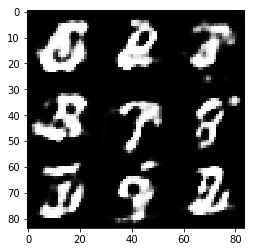

Epoch 1/2... Discriminator Loss: 0.4937... Generator Loss: 2.3787
Epoch 1/2... Discriminator Loss: 0.5840... Generator Loss: 2.7037
Epoch 1/2... Discriminator Loss: 0.5629... Generator Loss: 1.8296
Epoch 1/2... Discriminator Loss: 0.6166... Generator Loss: 1.7469
Epoch 1/2... Discriminator Loss: 0.5899... Generator Loss: 2.9667
Epoch 1/2... Discriminator Loss: 0.5707... Generator Loss: 2.1875
Epoch 1/2... Discriminator Loss: 0.4936... Generator Loss: 2.4274
Epoch 1/2... Discriminator Loss: 0.5671... Generator Loss: 2.3762
Epoch 1/2... Discriminator Loss: 0.5936... Generator Loss: 2.0462
Epoch 1/2... Discriminator Loss: 0.7285... Generator Loss: 1.2967


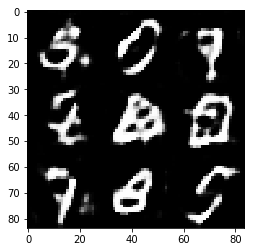

Epoch 1/2... Discriminator Loss: 0.5134... Generator Loss: 2.5424
Epoch 1/2... Discriminator Loss: 0.7557... Generator Loss: 3.6390
Epoch 1/2... Discriminator Loss: 0.7298... Generator Loss: 1.4234
Epoch 1/2... Discriminator Loss: 0.5920... Generator Loss: 2.5765
Epoch 1/2... Discriminator Loss: 0.6906... Generator Loss: 1.4727
Epoch 1/2... Discriminator Loss: 0.5774... Generator Loss: 2.2273
Epoch 1/2... Discriminator Loss: 0.8905... Generator Loss: 3.6277
Epoch 1/2... Discriminator Loss: 0.5425... Generator Loss: 1.9153
Epoch 1/2... Discriminator Loss: 0.8112... Generator Loss: 1.1280
Epoch 1/2... Discriminator Loss: 0.9160... Generator Loss: 3.3882


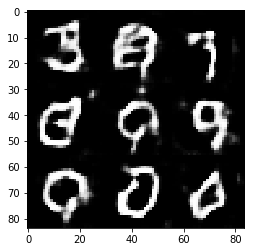

Epoch 1/2... Discriminator Loss: 0.6239... Generator Loss: 2.8411
Epoch 1/2... Discriminator Loss: 0.6476... Generator Loss: 1.9186
Epoch 1/2... Discriminator Loss: 0.6449... Generator Loss: 2.8363
Epoch 1/2... Discriminator Loss: 0.7043... Generator Loss: 1.4407
Epoch 1/2... Discriminator Loss: 0.6957... Generator Loss: 1.7050
Epoch 1/2... Discriminator Loss: 0.5746... Generator Loss: 2.0388
Epoch 1/2... Discriminator Loss: 0.5526... Generator Loss: 1.7946
Epoch 1/2... Discriminator Loss: 0.8607... Generator Loss: 1.1585
Epoch 1/2... Discriminator Loss: 0.6181... Generator Loss: 2.2518
Epoch 1/2... Discriminator Loss: 0.5948... Generator Loss: 2.3009


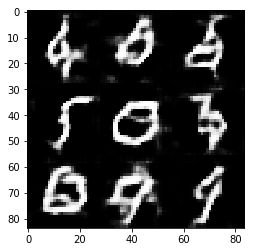

Epoch 1/2... Discriminator Loss: 0.6993... Generator Loss: 1.2788
Epoch 1/2... Discriminator Loss: 0.7597... Generator Loss: 1.5225
Epoch 1/2... Discriminator Loss: 0.6255... Generator Loss: 2.0442
Epoch 1/2... Discriminator Loss: 0.6227... Generator Loss: 1.6091
Epoch 1/2... Discriminator Loss: 0.6379... Generator Loss: 1.6935
Epoch 1/2... Discriminator Loss: 0.8263... Generator Loss: 1.9587
Epoch 1/2... Discriminator Loss: 0.7121... Generator Loss: 2.0842
Epoch 1/2... Discriminator Loss: 0.8088... Generator Loss: 1.1327
Epoch 1/2... Discriminator Loss: 0.8911... Generator Loss: 2.6688
Epoch 1/2... Discriminator Loss: 0.6400... Generator Loss: 1.6890


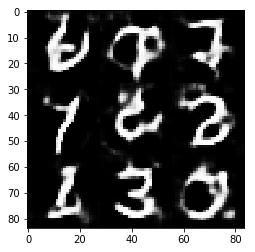

Epoch 1/2... Discriminator Loss: 0.6356... Generator Loss: 1.9007
Epoch 1/2... Discriminator Loss: 0.9747... Generator Loss: 3.2800
Epoch 1/2... Discriminator Loss: 0.6097... Generator Loss: 2.1798
Epoch 1/2... Discriminator Loss: 0.9175... Generator Loss: 2.3630
Epoch 1/2... Discriminator Loss: 1.1096... Generator Loss: 0.9128
Epoch 1/2... Discriminator Loss: 0.6764... Generator Loss: 1.9644
Epoch 1/2... Discriminator Loss: 0.7461... Generator Loss: 1.6125
Epoch 1/2... Discriminator Loss: 0.7560... Generator Loss: 2.7615
Epoch 1/2... Discriminator Loss: 0.7381... Generator Loss: 1.4259
Epoch 1/2... Discriminator Loss: 1.1808... Generator Loss: 0.8119


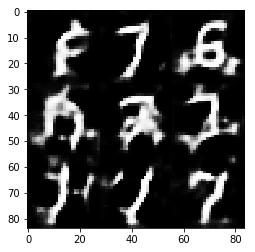

Epoch 1/2... Discriminator Loss: 0.5950... Generator Loss: 2.0501
Epoch 1/2... Discriminator Loss: 0.6656... Generator Loss: 2.0437
Epoch 1/2... Discriminator Loss: 1.7600... Generator Loss: 4.4012
Epoch 2/2... Discriminator Loss: 0.6222... Generator Loss: 2.6050
Epoch 2/2... Discriminator Loss: 0.6018... Generator Loss: 2.1935
Epoch 2/2... Discriminator Loss: 0.6131... Generator Loss: 1.7248
Epoch 2/2... Discriminator Loss: 0.6775... Generator Loss: 2.6276
Epoch 2/2... Discriminator Loss: 0.6512... Generator Loss: 1.4413
Epoch 2/2... Discriminator Loss: 0.6570... Generator Loss: 2.5066
Epoch 2/2... Discriminator Loss: 0.6911... Generator Loss: 2.3911


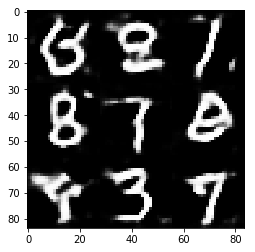

Epoch 2/2... Discriminator Loss: 0.6650... Generator Loss: 1.6147
Epoch 2/2... Discriminator Loss: 0.5929... Generator Loss: 1.8571
Epoch 2/2... Discriminator Loss: 0.5801... Generator Loss: 1.7058
Epoch 2/2... Discriminator Loss: 0.8118... Generator Loss: 2.9405
Epoch 2/2... Discriminator Loss: 0.6054... Generator Loss: 1.6550
Epoch 2/2... Discriminator Loss: 0.9204... Generator Loss: 2.9790
Epoch 2/2... Discriminator Loss: 0.6611... Generator Loss: 1.4985
Epoch 2/2... Discriminator Loss: 0.6694... Generator Loss: 1.5031
Epoch 2/2... Discriminator Loss: 0.6099... Generator Loss: 2.4920
Epoch 2/2... Discriminator Loss: 0.6084... Generator Loss: 2.0212


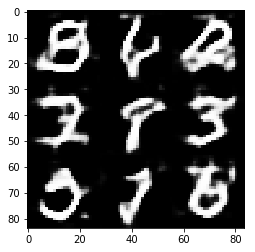

Epoch 2/2... Discriminator Loss: 0.6078... Generator Loss: 1.8948
Epoch 2/2... Discriminator Loss: 0.7726... Generator Loss: 2.6792
Epoch 2/2... Discriminator Loss: 0.9010... Generator Loss: 1.1099
Epoch 2/2... Discriminator Loss: 0.7958... Generator Loss: 1.1764
Epoch 2/2... Discriminator Loss: 0.6163... Generator Loss: 1.7302
Epoch 2/2... Discriminator Loss: 0.7952... Generator Loss: 1.3157
Epoch 2/2... Discriminator Loss: 0.9169... Generator Loss: 3.3092
Epoch 2/2... Discriminator Loss: 0.6006... Generator Loss: 2.1092
Epoch 2/2... Discriminator Loss: 0.5950... Generator Loss: 1.7634
Epoch 2/2... Discriminator Loss: 0.6205... Generator Loss: 1.7264


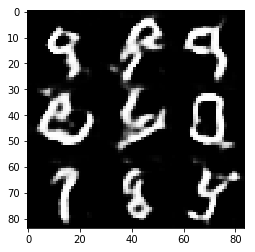

Epoch 2/2... Discriminator Loss: 0.5742... Generator Loss: 1.5255
Epoch 2/2... Discriminator Loss: 0.5737... Generator Loss: 2.2418
Epoch 2/2... Discriminator Loss: 0.6975... Generator Loss: 1.9694
Epoch 2/2... Discriminator Loss: 0.6152... Generator Loss: 2.7148
Epoch 2/2... Discriminator Loss: 0.6183... Generator Loss: 2.3582
Epoch 2/2... Discriminator Loss: 0.8184... Generator Loss: 2.8643
Epoch 2/2... Discriminator Loss: 1.3451... Generator Loss: 3.7382
Epoch 2/2... Discriminator Loss: 0.5916... Generator Loss: 2.2206
Epoch 2/2... Discriminator Loss: 0.5555... Generator Loss: 2.2311
Epoch 2/2... Discriminator Loss: 0.6102... Generator Loss: 2.4363


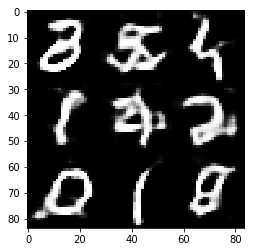

Epoch 2/2... Discriminator Loss: 0.5727... Generator Loss: 2.4181
Epoch 2/2... Discriminator Loss: 0.6508... Generator Loss: 1.9710
Epoch 2/2... Discriminator Loss: 0.6332... Generator Loss: 1.6274
Epoch 2/2... Discriminator Loss: 0.6131... Generator Loss: 2.2384
Epoch 2/2... Discriminator Loss: 0.5719... Generator Loss: 2.3039
Epoch 2/2... Discriminator Loss: 0.6346... Generator Loss: 2.6624
Epoch 2/2... Discriminator Loss: 0.6877... Generator Loss: 2.2170
Epoch 2/2... Discriminator Loss: 0.6532... Generator Loss: 1.5415
Epoch 2/2... Discriminator Loss: 0.5895... Generator Loss: 2.1773
Epoch 2/2... Discriminator Loss: 0.5574... Generator Loss: 2.1433


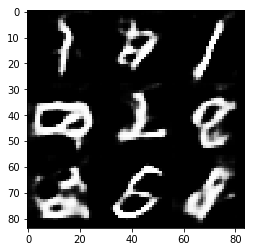

Epoch 2/2... Discriminator Loss: 0.5857... Generator Loss: 1.8991
Epoch 2/2... Discriminator Loss: 0.5657... Generator Loss: 2.4946
Epoch 2/2... Discriminator Loss: 0.7701... Generator Loss: 3.3888
Epoch 2/2... Discriminator Loss: 0.6434... Generator Loss: 2.8316
Epoch 2/2... Discriminator Loss: 0.5654... Generator Loss: 2.0504
Epoch 2/2... Discriminator Loss: 0.6963... Generator Loss: 3.6979
Epoch 2/2... Discriminator Loss: 0.6780... Generator Loss: 1.3982
Epoch 2/2... Discriminator Loss: 0.6292... Generator Loss: 2.1767
Epoch 2/2... Discriminator Loss: 0.5685... Generator Loss: 2.1375
Epoch 2/2... Discriminator Loss: 0.5768... Generator Loss: 2.3758


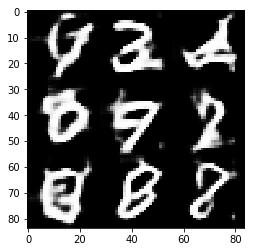

Epoch 2/2... Discriminator Loss: 0.6037... Generator Loss: 1.3774
Epoch 2/2... Discriminator Loss: 0.5229... Generator Loss: 2.1739
Epoch 2/2... Discriminator Loss: 0.4879... Generator Loss: 2.2897
Epoch 2/2... Discriminator Loss: 0.7220... Generator Loss: 1.3466
Epoch 2/2... Discriminator Loss: 0.5486... Generator Loss: 2.1800
Epoch 2/2... Discriminator Loss: 0.5175... Generator Loss: 2.0250
Epoch 2/2... Discriminator Loss: 0.5033... Generator Loss: 2.6414
Epoch 2/2... Discriminator Loss: 0.5786... Generator Loss: 2.7588
Epoch 2/2... Discriminator Loss: 0.5160... Generator Loss: 2.4990
Epoch 2/2... Discriminator Loss: 0.5723... Generator Loss: 1.6618


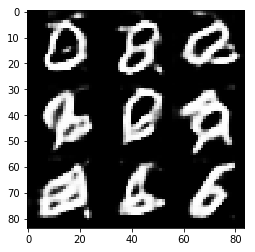

Epoch 2/2... Discriminator Loss: 0.4947... Generator Loss: 1.7788
Epoch 2/2... Discriminator Loss: 0.5328... Generator Loss: 2.6940
Epoch 2/2... Discriminator Loss: 0.5063... Generator Loss: 2.5798
Epoch 2/2... Discriminator Loss: 0.4834... Generator Loss: 2.5464
Epoch 2/2... Discriminator Loss: 0.6195... Generator Loss: 1.5405
Epoch 2/2... Discriminator Loss: 0.5004... Generator Loss: 2.9162
Epoch 2/2... Discriminator Loss: 0.4999... Generator Loss: 2.5091
Epoch 2/2... Discriminator Loss: 0.5199... Generator Loss: 2.9408
Epoch 2/2... Discriminator Loss: 0.5505... Generator Loss: 2.7913
Epoch 2/2... Discriminator Loss: 0.6497... Generator Loss: 1.7229


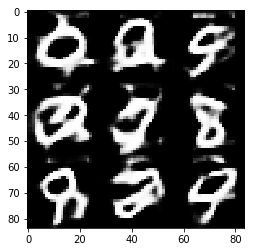

Epoch 2/2... Discriminator Loss: 0.4843... Generator Loss: 2.8388
Epoch 2/2... Discriminator Loss: 0.5930... Generator Loss: 1.7218
Epoch 2/2... Discriminator Loss: 0.5770... Generator Loss: 2.2449
Epoch 2/2... Discriminator Loss: 0.6497... Generator Loss: 3.3025
Epoch 2/2... Discriminator Loss: 0.5056... Generator Loss: 2.9598
Epoch 2/2... Discriminator Loss: 0.5308... Generator Loss: 3.0328
Epoch 2/2... Discriminator Loss: 0.5083... Generator Loss: 1.8908
Epoch 2/2... Discriminator Loss: 0.4905... Generator Loss: 2.1408
Epoch 2/2... Discriminator Loss: 0.4957... Generator Loss: 2.7129
Epoch 2/2... Discriminator Loss: 0.5221... Generator Loss: 2.2118


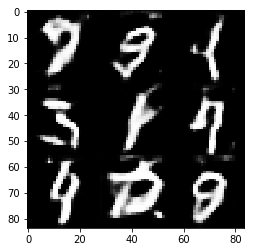

Epoch 2/2... Discriminator Loss: 0.5128... Generator Loss: 2.0740
Epoch 2/2... Discriminator Loss: 0.4739... Generator Loss: 2.0701
Epoch 2/2... Discriminator Loss: 0.5222... Generator Loss: 2.0613
Epoch 2/2... Discriminator Loss: 0.5481... Generator Loss: 1.9760
Epoch 2/2... Discriminator Loss: 0.4888... Generator Loss: 2.5244
Epoch 2/2... Discriminator Loss: 0.4811... Generator Loss: 2.0833
Epoch 2/2... Discriminator Loss: 0.5022... Generator Loss: 2.0881


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5
print_every = 10
show_every= 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5022... Generator Loss: 2.0849
Epoch 1/1... Discriminator Loss: 0.4570... Generator Loss: 2.8786
Epoch 1/1... Discriminator Loss: 0.4383... Generator Loss: 2.6971
Epoch 1/1... Discriminator Loss: 0.4382... Generator Loss: 3.1711
Epoch 1/1... Discriminator Loss: 0.4362... Generator Loss: 3.0171
Epoch 1/1... Discriminator Loss: 0.4361... Generator Loss: 3.0280
Epoch 1/1... Discriminator Loss: 0.4280... Generator Loss: 2.8206
Epoch 1/1... Discriminator Loss: 0.4700... Generator Loss: 3.3636
Epoch 1/1... Discriminator Loss: 0.4463... Generator Loss: 2.6583
Epoch 1/1... Discriminator Loss: 0.5061... Generator Loss: 4.2930


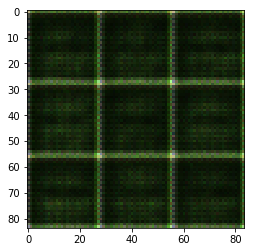

Epoch 1/1... Discriminator Loss: 0.4782... Generator Loss: 2.4086
Epoch 1/1... Discriminator Loss: 0.4582... Generator Loss: 2.9867
Epoch 1/1... Discriminator Loss: 0.4624... Generator Loss: 2.3629
Epoch 1/1... Discriminator Loss: 0.4591... Generator Loss: 2.4847
Epoch 1/1... Discriminator Loss: 0.4582... Generator Loss: 2.3124
Epoch 1/1... Discriminator Loss: 0.4444... Generator Loss: 2.6717
Epoch 1/1... Discriminator Loss: 0.4425... Generator Loss: 2.8490
Epoch 1/1... Discriminator Loss: 0.4790... Generator Loss: 2.4187
Epoch 1/1... Discriminator Loss: 0.4517... Generator Loss: 2.8131
Epoch 1/1... Discriminator Loss: 0.4507... Generator Loss: 3.3728


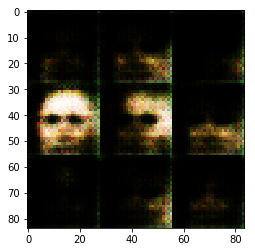

Epoch 1/1... Discriminator Loss: 0.4339... Generator Loss: 2.5504
Epoch 1/1... Discriminator Loss: 0.4491... Generator Loss: 2.4549
Epoch 1/1... Discriminator Loss: 0.5146... Generator Loss: 2.0141
Epoch 1/1... Discriminator Loss: 0.4309... Generator Loss: 3.0869
Epoch 1/1... Discriminator Loss: 0.4257... Generator Loss: 2.9951
Epoch 1/1... Discriminator Loss: 0.4229... Generator Loss: 2.6882
Epoch 1/1... Discriminator Loss: 0.4177... Generator Loss: 2.8284
Epoch 1/1... Discriminator Loss: 0.4230... Generator Loss: 2.5453
Epoch 1/1... Discriminator Loss: 0.4358... Generator Loss: 3.4083
Epoch 1/1... Discriminator Loss: 0.4401... Generator Loss: 3.2092


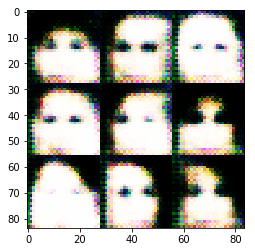

Epoch 1/1... Discriminator Loss: 0.4302... Generator Loss: 2.4048
Epoch 1/1... Discriminator Loss: 0.4596... Generator Loss: 2.2814
Epoch 1/1... Discriminator Loss: 0.4261... Generator Loss: 3.2731
Epoch 1/1... Discriminator Loss: 0.4236... Generator Loss: 2.8159
Epoch 1/1... Discriminator Loss: 0.4221... Generator Loss: 2.9207
Epoch 1/1... Discriminator Loss: 0.4162... Generator Loss: 2.8935
Epoch 1/1... Discriminator Loss: 0.4225... Generator Loss: 3.0971
Epoch 1/1... Discriminator Loss: 0.4241... Generator Loss: 2.6349
Epoch 1/1... Discriminator Loss: 0.4181... Generator Loss: 3.0342
Epoch 1/1... Discriminator Loss: 0.4357... Generator Loss: 2.1893


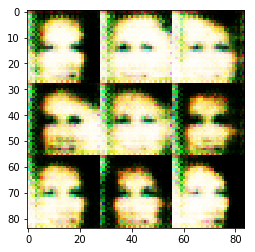

Epoch 1/1... Discriminator Loss: 0.6456... Generator Loss: 1.4505
Epoch 1/1... Discriminator Loss: 0.4443... Generator Loss: 2.9302
Epoch 1/1... Discriminator Loss: 0.4206... Generator Loss: 3.0721
Epoch 1/1... Discriminator Loss: 0.4277... Generator Loss: 2.5490
Epoch 1/1... Discriminator Loss: 2.2842... Generator Loss: 7.7143
Epoch 1/1... Discriminator Loss: 0.4600... Generator Loss: 2.6754
Epoch 1/1... Discriminator Loss: 0.4261... Generator Loss: 3.1228
Epoch 1/1... Discriminator Loss: 0.4287... Generator Loss: 2.4567
Epoch 1/1... Discriminator Loss: 0.4234... Generator Loss: 2.6933
Epoch 1/1... Discriminator Loss: 0.4214... Generator Loss: 2.9689


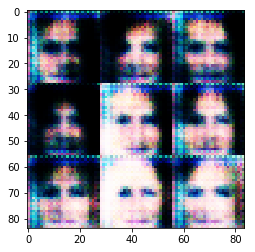

Epoch 1/1... Discriminator Loss: 0.4161... Generator Loss: 2.9298
Epoch 1/1... Discriminator Loss: 0.4180... Generator Loss: 3.1695
Epoch 1/1... Discriminator Loss: 0.4747... Generator Loss: 1.9916
Epoch 1/1... Discriminator Loss: 0.4165... Generator Loss: 2.9417
Epoch 1/1... Discriminator Loss: 0.4198... Generator Loss: 3.0962
Epoch 1/1... Discriminator Loss: 0.4185... Generator Loss: 2.9720
Epoch 1/1... Discriminator Loss: 0.4185... Generator Loss: 3.1777
Epoch 1/1... Discriminator Loss: 0.4189... Generator Loss: 2.6880
Epoch 1/1... Discriminator Loss: 0.4283... Generator Loss: 2.9116
Epoch 1/1... Discriminator Loss: 0.6161... Generator Loss: 1.6834


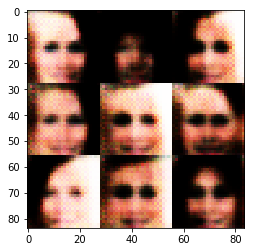

Epoch 1/1... Discriminator Loss: 0.5199... Generator Loss: 2.2028
Epoch 1/1... Discriminator Loss: 0.4464... Generator Loss: 2.6179
Epoch 1/1... Discriminator Loss: 0.4644... Generator Loss: 3.0309
Epoch 1/1... Discriminator Loss: 0.4608... Generator Loss: 2.3516
Epoch 1/1... Discriminator Loss: 0.4674... Generator Loss: 3.2399
Epoch 1/1... Discriminator Loss: 0.4832... Generator Loss: 3.6239
Epoch 1/1... Discriminator Loss: 0.4423... Generator Loss: 2.5512
Epoch 1/1... Discriminator Loss: 0.4356... Generator Loss: 3.0791
Epoch 1/1... Discriminator Loss: 0.4426... Generator Loss: 2.4114
Epoch 1/1... Discriminator Loss: 0.4860... Generator Loss: 2.0711


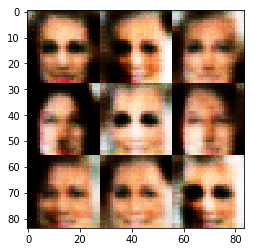

Epoch 1/1... Discriminator Loss: 0.4433... Generator Loss: 2.6062
Epoch 1/1... Discriminator Loss: 0.4332... Generator Loss: 3.0349
Epoch 1/1... Discriminator Loss: 0.4242... Generator Loss: 2.5222
Epoch 1/1... Discriminator Loss: 0.4665... Generator Loss: 4.1615
Epoch 1/1... Discriminator Loss: 0.4498... Generator Loss: 2.4781
Epoch 1/1... Discriminator Loss: 0.4319... Generator Loss: 2.9371
Epoch 1/1... Discriminator Loss: 1.0171... Generator Loss: 4.8663
Epoch 1/1... Discriminator Loss: 0.6974... Generator Loss: 1.4840
Epoch 1/1... Discriminator Loss: 0.4413... Generator Loss: 2.4699
Epoch 1/1... Discriminator Loss: 0.4685... Generator Loss: 2.1767


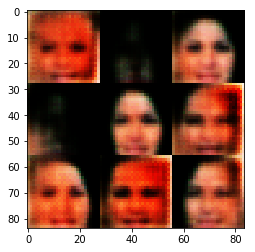

Epoch 1/1... Discriminator Loss: 0.4525... Generator Loss: 2.1660
Epoch 1/1... Discriminator Loss: 0.4666... Generator Loss: 2.4855
Epoch 1/1... Discriminator Loss: 0.5165... Generator Loss: 1.8958
Epoch 1/1... Discriminator Loss: 0.4533... Generator Loss: 2.7907
Epoch 1/1... Discriminator Loss: 0.7720... Generator Loss: 1.1402
Epoch 1/1... Discriminator Loss: 0.5470... Generator Loss: 2.0356
Epoch 1/1... Discriminator Loss: 0.4831... Generator Loss: 2.3184
Epoch 1/1... Discriminator Loss: 0.4771... Generator Loss: 2.4072
Epoch 1/1... Discriminator Loss: 0.5428... Generator Loss: 1.7341
Epoch 1/1... Discriminator Loss: 0.4573... Generator Loss: 2.5369


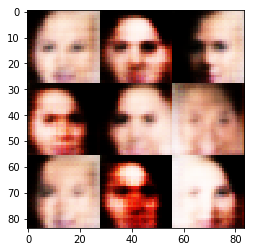

Epoch 1/1... Discriminator Loss: 0.4999... Generator Loss: 2.0182
Epoch 1/1... Discriminator Loss: 0.4734... Generator Loss: 2.1939
Epoch 1/1... Discriminator Loss: 0.6348... Generator Loss: 3.9240
Epoch 1/1... Discriminator Loss: 0.4512... Generator Loss: 2.7444
Epoch 1/1... Discriminator Loss: 0.4900... Generator Loss: 2.5894
Epoch 1/1... Discriminator Loss: 0.4581... Generator Loss: 2.3929
Epoch 1/1... Discriminator Loss: 0.4517... Generator Loss: 2.7920
Epoch 1/1... Discriminator Loss: 0.8557... Generator Loss: 5.1308
Epoch 1/1... Discriminator Loss: 0.5611... Generator Loss: 2.9909
Epoch 1/1... Discriminator Loss: 0.5147... Generator Loss: 2.5769


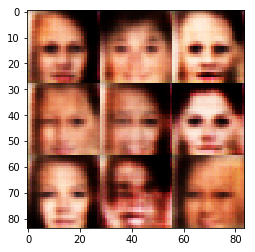

Epoch 1/1... Discriminator Loss: 0.4873... Generator Loss: 2.6417
Epoch 1/1... Discriminator Loss: 0.5886... Generator Loss: 2.8196
Epoch 1/1... Discriminator Loss: 0.4990... Generator Loss: 2.0133
Epoch 1/1... Discriminator Loss: 0.4878... Generator Loss: 2.8745
Epoch 1/1... Discriminator Loss: 0.6883... Generator Loss: 1.4455
Epoch 1/1... Discriminator Loss: 0.4769... Generator Loss: 2.4354
Epoch 1/1... Discriminator Loss: 0.4839... Generator Loss: 2.4088
Epoch 1/1... Discriminator Loss: 0.5092... Generator Loss: 2.3969
Epoch 1/1... Discriminator Loss: 0.8243... Generator Loss: 1.0400
Epoch 1/1... Discriminator Loss: 0.5072... Generator Loss: 3.4104


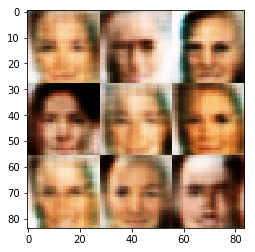

Epoch 1/1... Discriminator Loss: 0.4829... Generator Loss: 2.6358
Epoch 1/1... Discriminator Loss: 0.7400... Generator Loss: 2.3922
Epoch 1/1... Discriminator Loss: 0.5919... Generator Loss: 1.6443
Epoch 1/1... Discriminator Loss: 0.5515... Generator Loss: 2.3547
Epoch 1/1... Discriminator Loss: 0.5187... Generator Loss: 2.4152
Epoch 1/1... Discriminator Loss: 0.6663... Generator Loss: 1.4822
Epoch 1/1... Discriminator Loss: 0.6736... Generator Loss: 2.5163
Epoch 1/1... Discriminator Loss: 0.5161... Generator Loss: 2.4098
Epoch 1/1... Discriminator Loss: 0.5128... Generator Loss: 2.6563
Epoch 1/1... Discriminator Loss: 0.7581... Generator Loss: 1.2331


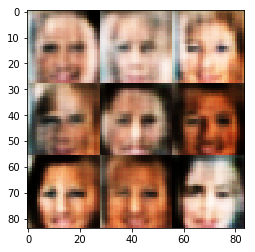

Epoch 1/1... Discriminator Loss: 0.5422... Generator Loss: 2.3651
Epoch 1/1... Discriminator Loss: 0.8764... Generator Loss: 0.9613
Epoch 1/1... Discriminator Loss: 0.5466... Generator Loss: 2.0458
Epoch 1/1... Discriminator Loss: 0.8466... Generator Loss: 0.9662
Epoch 1/1... Discriminator Loss: 0.5855... Generator Loss: 2.2196
Epoch 1/1... Discriminator Loss: 0.6556... Generator Loss: 1.5925
Epoch 1/1... Discriminator Loss: 0.7088... Generator Loss: 1.2358
Epoch 1/1... Discriminator Loss: 0.5244... Generator Loss: 2.4913
Epoch 1/1... Discriminator Loss: 0.9980... Generator Loss: 1.0560
Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 1.0885


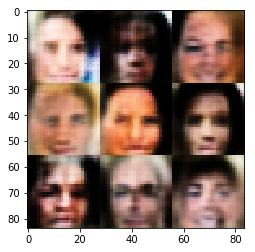

Epoch 1/1... Discriminator Loss: 0.6607... Generator Loss: 1.6354
Epoch 1/1... Discriminator Loss: 0.5825... Generator Loss: 1.8527
Epoch 1/1... Discriminator Loss: 0.6601... Generator Loss: 2.0250
Epoch 1/1... Discriminator Loss: 0.6025... Generator Loss: 2.3360
Epoch 1/1... Discriminator Loss: 0.5722... Generator Loss: 1.8466
Epoch 1/1... Discriminator Loss: 0.5848... Generator Loss: 2.0980
Epoch 1/1... Discriminator Loss: 0.5591... Generator Loss: 1.9468
Epoch 1/1... Discriminator Loss: 0.6529... Generator Loss: 1.5614
Epoch 1/1... Discriminator Loss: 0.8886... Generator Loss: 1.0359
Epoch 1/1... Discriminator Loss: 0.5308... Generator Loss: 2.0618


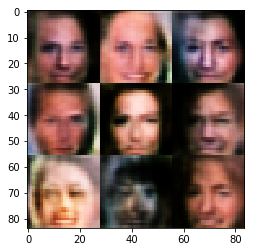

Epoch 1/1... Discriminator Loss: 0.6633... Generator Loss: 1.4414
Epoch 1/1... Discriminator Loss: 0.7631... Generator Loss: 1.2862
Epoch 1/1... Discriminator Loss: 0.9741... Generator Loss: 1.1239
Epoch 1/1... Discriminator Loss: 0.7667... Generator Loss: 1.0865
Epoch 1/1... Discriminator Loss: 0.6638... Generator Loss: 1.9445
Epoch 1/1... Discriminator Loss: 0.6133... Generator Loss: 1.8918
Epoch 1/1... Discriminator Loss: 0.6676... Generator Loss: 1.6203
Epoch 1/1... Discriminator Loss: 0.8055... Generator Loss: 1.0814
Epoch 1/1... Discriminator Loss: 0.6540... Generator Loss: 1.8220
Epoch 1/1... Discriminator Loss: 0.6639... Generator Loss: 2.5333


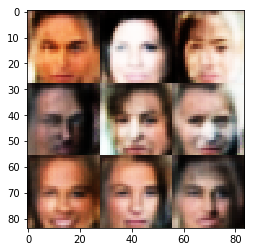

Epoch 1/1... Discriminator Loss: 0.6223... Generator Loss: 2.4347
Epoch 1/1... Discriminator Loss: 0.6794... Generator Loss: 1.4266
Epoch 1/1... Discriminator Loss: 0.9471... Generator Loss: 1.0682
Epoch 1/1... Discriminator Loss: 0.8204... Generator Loss: 1.3005
Epoch 1/1... Discriminator Loss: 0.6671... Generator Loss: 1.8140
Epoch 1/1... Discriminator Loss: 0.8646... Generator Loss: 1.1071
Epoch 1/1... Discriminator Loss: 0.7181... Generator Loss: 1.4665
Epoch 1/1... Discriminator Loss: 0.7768... Generator Loss: 2.3427
Epoch 1/1... Discriminator Loss: 0.7901... Generator Loss: 1.2887
Epoch 1/1... Discriminator Loss: 0.7295... Generator Loss: 1.6716


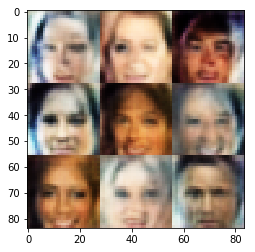

Epoch 1/1... Discriminator Loss: 0.7534... Generator Loss: 1.9009
Epoch 1/1... Discriminator Loss: 0.6033... Generator Loss: 1.8012
Epoch 1/1... Discriminator Loss: 0.7285... Generator Loss: 1.6468
Epoch 1/1... Discriminator Loss: 0.6445... Generator Loss: 1.6217
Epoch 1/1... Discriminator Loss: 0.7224... Generator Loss: 1.9083
Epoch 1/1... Discriminator Loss: 0.7393... Generator Loss: 2.3892
Epoch 1/1... Discriminator Loss: 0.6544... Generator Loss: 1.4579
Epoch 1/1... Discriminator Loss: 0.7114... Generator Loss: 1.7111
Epoch 1/1... Discriminator Loss: 0.7551... Generator Loss: 2.3625
Epoch 1/1... Discriminator Loss: 0.6404... Generator Loss: 1.5565


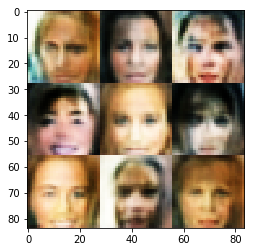

Epoch 1/1... Discriminator Loss: 0.6693... Generator Loss: 2.1904
Epoch 1/1... Discriminator Loss: 0.6202... Generator Loss: 1.8667
Epoch 1/1... Discriminator Loss: 0.8278... Generator Loss: 1.0939
Epoch 1/1... Discriminator Loss: 0.8359... Generator Loss: 1.4438
Epoch 1/1... Discriminator Loss: 0.8538... Generator Loss: 1.0646
Epoch 1/1... Discriminator Loss: 0.6341... Generator Loss: 1.9925
Epoch 1/1... Discriminator Loss: 0.7864... Generator Loss: 1.8763
Epoch 1/1... Discriminator Loss: 0.6726... Generator Loss: 1.6803
Epoch 1/1... Discriminator Loss: 0.7602... Generator Loss: 1.9830
Epoch 1/1... Discriminator Loss: 0.7445... Generator Loss: 1.5451


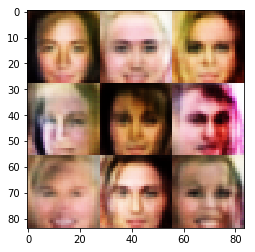

Epoch 1/1... Discriminator Loss: 0.6843... Generator Loss: 1.4417
Epoch 1/1... Discriminator Loss: 0.6703... Generator Loss: 2.0796
Epoch 1/1... Discriminator Loss: 0.6718... Generator Loss: 1.6911
Epoch 1/1... Discriminator Loss: 0.9690... Generator Loss: 2.6912
Epoch 1/1... Discriminator Loss: 0.7047... Generator Loss: 1.2128
Epoch 1/1... Discriminator Loss: 0.8994... Generator Loss: 2.5605
Epoch 1/1... Discriminator Loss: 0.6349... Generator Loss: 1.3846
Epoch 1/1... Discriminator Loss: 0.8224... Generator Loss: 1.2726
Epoch 1/1... Discriminator Loss: 0.7713... Generator Loss: 1.2579
Epoch 1/1... Discriminator Loss: 0.7494... Generator Loss: 2.0608


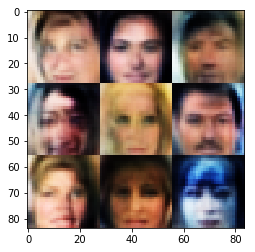

Epoch 1/1... Discriminator Loss: 0.7208... Generator Loss: 1.6353
Epoch 1/1... Discriminator Loss: 0.6668... Generator Loss: 1.6379
Epoch 1/1... Discriminator Loss: 0.8001... Generator Loss: 1.9139
Epoch 1/1... Discriminator Loss: 0.6945... Generator Loss: 2.0870
Epoch 1/1... Discriminator Loss: 0.8682... Generator Loss: 1.0721
Epoch 1/1... Discriminator Loss: 0.7061... Generator Loss: 1.4593
Epoch 1/1... Discriminator Loss: 0.7802... Generator Loss: 1.2018
Epoch 1/1... Discriminator Loss: 0.7437... Generator Loss: 1.0293
Epoch 1/1... Discriminator Loss: 0.6532... Generator Loss: 1.4701
Epoch 1/1... Discriminator Loss: 0.6867... Generator Loss: 1.8272


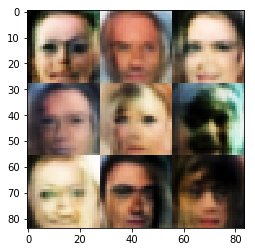

Epoch 1/1... Discriminator Loss: 0.7838... Generator Loss: 1.8676
Epoch 1/1... Discriminator Loss: 0.8865... Generator Loss: 0.8827
Epoch 1/1... Discriminator Loss: 0.8438... Generator Loss: 1.3127
Epoch 1/1... Discriminator Loss: 0.7304... Generator Loss: 1.7566
Epoch 1/1... Discriminator Loss: 0.6613... Generator Loss: 1.7158
Epoch 1/1... Discriminator Loss: 0.8777... Generator Loss: 2.2828
Epoch 1/1... Discriminator Loss: 0.7597... Generator Loss: 2.5547
Epoch 1/1... Discriminator Loss: 0.6679... Generator Loss: 1.6026
Epoch 1/1... Discriminator Loss: 0.6766... Generator Loss: 1.7353
Epoch 1/1... Discriminator Loss: 0.7861... Generator Loss: 1.2447


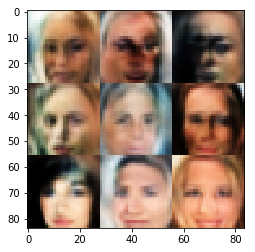

Epoch 1/1... Discriminator Loss: 0.7810... Generator Loss: 1.4698
Epoch 1/1... Discriminator Loss: 0.7685... Generator Loss: 1.1779
Epoch 1/1... Discriminator Loss: 0.6549... Generator Loss: 2.3948
Epoch 1/1... Discriminator Loss: 0.6165... Generator Loss: 1.5202
Epoch 1/1... Discriminator Loss: 0.7938... Generator Loss: 1.0857
Epoch 1/1... Discriminator Loss: 0.6757... Generator Loss: 1.7561
Epoch 1/1... Discriminator Loss: 0.7227... Generator Loss: 1.7479
Epoch 1/1... Discriminator Loss: 0.8359... Generator Loss: 1.1478
Epoch 1/1... Discriminator Loss: 0.8209... Generator Loss: 1.3249
Epoch 1/1... Discriminator Loss: 0.8590... Generator Loss: 2.7072


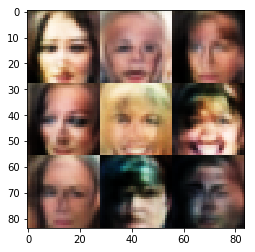

Epoch 1/1... Discriminator Loss: 0.7709... Generator Loss: 1.9669
Epoch 1/1... Discriminator Loss: 0.6873... Generator Loss: 1.5712
Epoch 1/1... Discriminator Loss: 0.8480... Generator Loss: 0.9636
Epoch 1/1... Discriminator Loss: 0.7445... Generator Loss: 1.5718
Epoch 1/1... Discriminator Loss: 0.7761... Generator Loss: 1.3694
Epoch 1/1... Discriminator Loss: 0.9789... Generator Loss: 0.8728
Epoch 1/1... Discriminator Loss: 0.8235... Generator Loss: 1.0160
Epoch 1/1... Discriminator Loss: 0.7548... Generator Loss: 1.8117
Epoch 1/1... Discriminator Loss: 0.7954... Generator Loss: 1.3080
Epoch 1/1... Discriminator Loss: 0.7952... Generator Loss: 1.8109


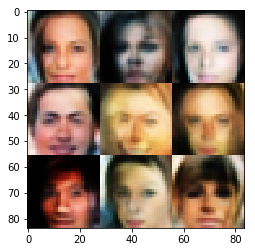

Epoch 1/1... Discriminator Loss: 0.7568... Generator Loss: 2.0507
Epoch 1/1... Discriminator Loss: 0.8437... Generator Loss: 2.0023
Epoch 1/1... Discriminator Loss: 0.6933... Generator Loss: 1.5100
Epoch 1/1... Discriminator Loss: 0.7412... Generator Loss: 1.8467
Epoch 1/1... Discriminator Loss: 0.6849... Generator Loss: 1.4442
Epoch 1/1... Discriminator Loss: 0.6807... Generator Loss: 1.3420
Epoch 1/1... Discriminator Loss: 0.8917... Generator Loss: 2.4750
Epoch 1/1... Discriminator Loss: 0.7141... Generator Loss: 1.7750
Epoch 1/1... Discriminator Loss: 0.7226... Generator Loss: 1.3056
Epoch 1/1... Discriminator Loss: 0.7508... Generator Loss: 1.6098


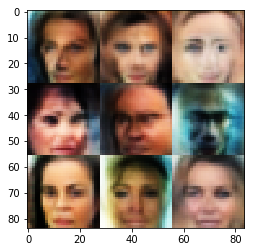

Epoch 1/1... Discriminator Loss: 0.7922... Generator Loss: 1.1344
Epoch 1/1... Discriminator Loss: 0.6570... Generator Loss: 1.7907
Epoch 1/1... Discriminator Loss: 0.7551... Generator Loss: 1.0149
Epoch 1/1... Discriminator Loss: 0.7393... Generator Loss: 1.4090
Epoch 1/1... Discriminator Loss: 0.7011... Generator Loss: 1.4663
Epoch 1/1... Discriminator Loss: 0.7301... Generator Loss: 1.4273
Epoch 1/1... Discriminator Loss: 0.8249... Generator Loss: 1.7542
Epoch 1/1... Discriminator Loss: 0.6769... Generator Loss: 1.4407
Epoch 1/1... Discriminator Loss: 0.8232... Generator Loss: 1.0637
Epoch 1/1... Discriminator Loss: 0.7059... Generator Loss: 1.1879


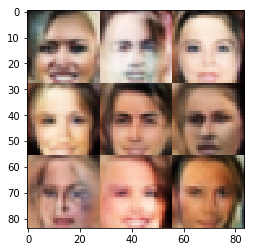

Epoch 1/1... Discriminator Loss: 0.8145... Generator Loss: 2.5256
Epoch 1/1... Discriminator Loss: 0.7429... Generator Loss: 1.6829
Epoch 1/1... Discriminator Loss: 0.8259... Generator Loss: 1.1226
Epoch 1/1... Discriminator Loss: 0.7219... Generator Loss: 1.9718
Epoch 1/1... Discriminator Loss: 0.7294... Generator Loss: 2.3262
Epoch 1/1... Discriminator Loss: 0.7716... Generator Loss: 1.0839
Epoch 1/1... Discriminator Loss: 0.7610... Generator Loss: 1.1226
Epoch 1/1... Discriminator Loss: 0.6917... Generator Loss: 1.7560
Epoch 1/1... Discriminator Loss: 0.7577... Generator Loss: 1.0941
Epoch 1/1... Discriminator Loss: 0.7138... Generator Loss: 1.4283


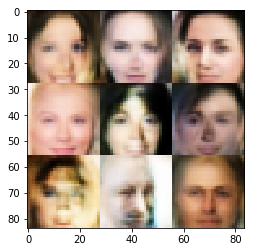

Epoch 1/1... Discriminator Loss: 0.7612... Generator Loss: 1.6854
Epoch 1/1... Discriminator Loss: 0.7363... Generator Loss: 1.4192
Epoch 1/1... Discriminator Loss: 0.7985... Generator Loss: 1.0200
Epoch 1/1... Discriminator Loss: 0.6372... Generator Loss: 1.9402
Epoch 1/1... Discriminator Loss: 0.9292... Generator Loss: 0.9538
Epoch 1/1... Discriminator Loss: 0.6809... Generator Loss: 1.5033
Epoch 1/1... Discriminator Loss: 0.6163... Generator Loss: 1.9275
Epoch 1/1... Discriminator Loss: 0.7604... Generator Loss: 1.5838
Epoch 1/1... Discriminator Loss: 0.6516... Generator Loss: 1.7723
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.7838


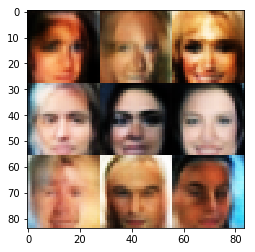

Epoch 1/1... Discriminator Loss: 0.7126... Generator Loss: 1.4426
Epoch 1/1... Discriminator Loss: 0.7337... Generator Loss: 1.4434
Epoch 1/1... Discriminator Loss: 0.7173... Generator Loss: 1.6903
Epoch 1/1... Discriminator Loss: 0.6355... Generator Loss: 1.5920
Epoch 1/1... Discriminator Loss: 0.7497... Generator Loss: 1.0906
Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 0.6730... Generator Loss: 1.7535
Epoch 1/1... Discriminator Loss: 1.0540... Generator Loss: 0.8999
Epoch 1/1... Discriminator Loss: 0.6533... Generator Loss: 1.8130
Epoch 1/1... Discriminator Loss: 0.6145... Generator Loss: 1.5832


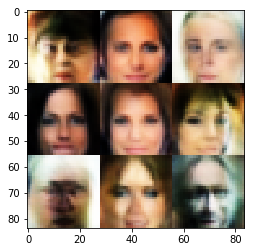

Epoch 1/1... Discriminator Loss: 0.7326... Generator Loss: 2.3025
Epoch 1/1... Discriminator Loss: 0.7599... Generator Loss: 1.6593
Epoch 1/1... Discriminator Loss: 0.8844... Generator Loss: 2.4032
Epoch 1/1... Discriminator Loss: 0.6206... Generator Loss: 1.7125
Epoch 1/1... Discriminator Loss: 0.6877... Generator Loss: 1.6037
Epoch 1/1... Discriminator Loss: 0.6468... Generator Loss: 1.8331
Epoch 1/1... Discriminator Loss: 0.7752... Generator Loss: 2.1065
Epoch 1/1... Discriminator Loss: 0.6287... Generator Loss: 1.4437
Epoch 1/1... Discriminator Loss: 0.6643... Generator Loss: 2.1526
Epoch 1/1... Discriminator Loss: 1.6320... Generator Loss: 0.3913


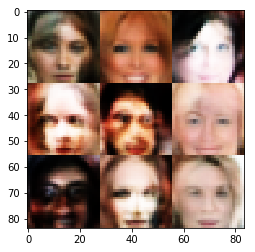

Epoch 1/1... Discriminator Loss: 0.7203... Generator Loss: 1.4571
Epoch 1/1... Discriminator Loss: 0.6757... Generator Loss: 1.4459
Epoch 1/1... Discriminator Loss: 0.6737... Generator Loss: 1.9253
Epoch 1/1... Discriminator Loss: 0.7271... Generator Loss: 1.2310
Epoch 1/1... Discriminator Loss: 0.6581... Generator Loss: 2.0276
Epoch 1/1... Discriminator Loss: 0.6663... Generator Loss: 1.6895
Epoch 1/1... Discriminator Loss: 0.6634... Generator Loss: 1.7281
Epoch 1/1... Discriminator Loss: 0.6973... Generator Loss: 1.3341
Epoch 1/1... Discriminator Loss: 0.6316... Generator Loss: 1.7966
Epoch 1/1... Discriminator Loss: 0.8635... Generator Loss: 1.8988


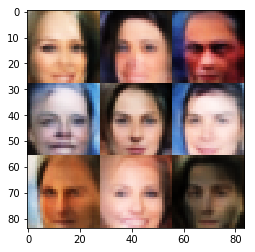

Epoch 1/1... Discriminator Loss: 0.6764... Generator Loss: 1.8856
Epoch 1/1... Discriminator Loss: 0.7447... Generator Loss: 2.3714
Epoch 1/1... Discriminator Loss: 0.9564... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 0.6498... Generator Loss: 1.4688
Epoch 1/1... Discriminator Loss: 0.6515... Generator Loss: 1.9159
Epoch 1/1... Discriminator Loss: 0.6506... Generator Loss: 1.4806
Epoch 1/1... Discriminator Loss: 0.5919... Generator Loss: 2.1705
Epoch 1/1... Discriminator Loss: 0.7430... Generator Loss: 1.9329
Epoch 1/1... Discriminator Loss: 1.7778... Generator Loss: 0.4018
Epoch 1/1... Discriminator Loss: 0.7142... Generator Loss: 1.5827


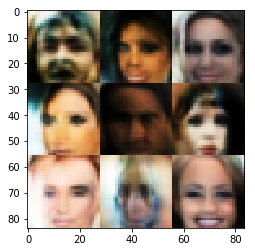

Epoch 1/1... Discriminator Loss: 0.6318... Generator Loss: 1.8362
Epoch 1/1... Discriminator Loss: 0.5808... Generator Loss: 2.4849
Epoch 1/1... Discriminator Loss: 0.6354... Generator Loss: 2.0258
Epoch 1/1... Discriminator Loss: 0.7123... Generator Loss: 1.2628
Epoch 1/1... Discriminator Loss: 0.6768... Generator Loss: 1.7526
Epoch 1/1... Discriminator Loss: 0.6672... Generator Loss: 1.9289


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5
print_every = 10
show_every= 100


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.